<a href="https://www.kaggle.com/code/chauhanadityacse/make-deep-feasible?scriptVersionId=269192431" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glaucoma-detection/glaucoma.csv
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/537.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/521.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/539.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/501.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/544.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/489.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/576.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/503.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_

In [2]:
# 📦 Core utilities
import os
import glob
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# 🧠 PyTorch essentials
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# ⚙️ Device setup & reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)


# Prepare Glaucoma Dataset

In [3]:
class FullGlaucomaDataset(Dataset):
    def __init__(self, fundus_dir, origa_mat, origa_img_dir, acrima_dir, transform=None):
        self.samples = []
        self.transform = transform
        
        # 1. Fundus images
        for label_dir in ["Glaucoma_Negative", "Glaucoma_Positive"]:
            full_dir = os.path.join(fundus_dir, "Train", label_dir)
            label = 0 if "Negative" in label_dir else 1
            for f in glob.glob(full_dir + "/*.jpg"):
                self.samples.append((f,label))
        
        # 2. ORIGA
        origa_data = scipy.io.loadmat(origa_mat)['Origa']
        # ORIGA MATLAB struct -> list of dict-like items
        for i in range(len(origa_data[0])):
            fname = origa_data[0][i]['Filename'][0]
            label = int(origa_data[0][i]['Glaucoma'][0][0])
            img_path = os.path.join(origa_img_dir, fname)
            if os.path.exists(img_path):
                self.samples.append((img_path, label))
        
        # 3. ACRIMA
        for f in glob.glob(acrima_dir + "/*.jpg"):
            fname = os.path.basename(f)
            # Glaucoma label if filename has _g_
            label = 1 if "_g_" in fname else 0
            self.samples.append((f,label))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


# Train/Validatin Split

In [4]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# 1️⃣ Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])


# 2️⃣ Paths
fundus_dir = "/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted"
origa_mat = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/OrigaList.mat"
origa_img_dir = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images"
acrima_dir = "/kaggle/input/glaucoma-detection/ACRIMA/Images"

# 3️⃣ Instantiate full dataset
full_dataset = FullGlaucomaDataset(
    fundus_dir=fundus_dir,      # <-- correct argument
    origa_mat=origa_mat,
    origa_img_dir=origa_img_dir,
    acrima_dir=acrima_dir,
    transform=transform_train
)

# 4️⃣ Train/validation split (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 5️⃣ DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Total samples:", len(full_dataset))
print("Train:", len(train_dataset), "Validation:", len(val_dataset))


Total samples: 1873
Train: 1498 Validation: 375


# Visualize Some Images

Training set samples:


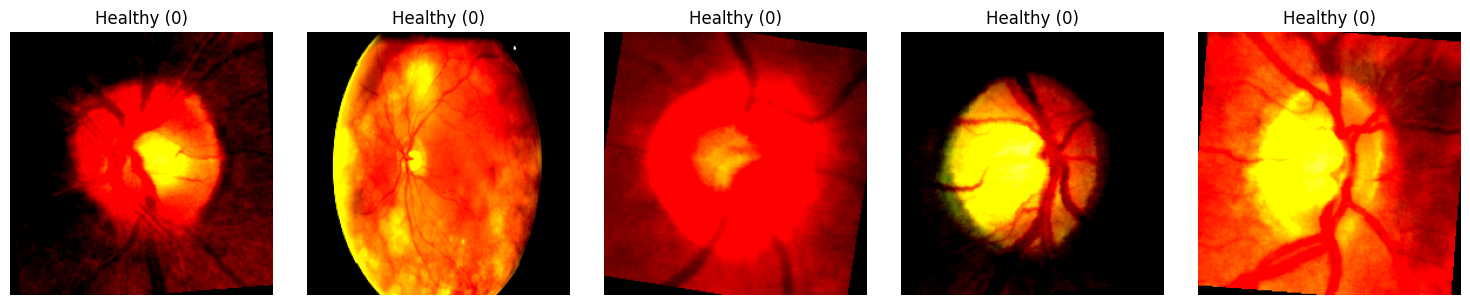

Validation set samples:


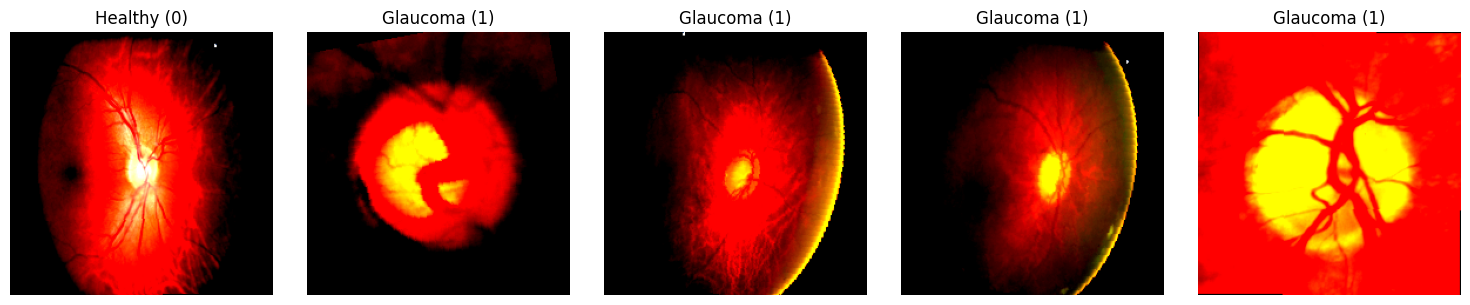

In [5]:
import matplotlib.pyplot as plt
import torch

# Label mapping
classes = ['Healthy (0)', 'Glaucoma (1)']

def show_samples(loader, num_samples=5):
    """
    Display sample RGB images from a DataLoader in a grid.
    """
    images, labels = next(iter(loader))  # get one batch
    num_samples = min(num_samples, len(images))
    
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).cpu()  # (C, H, W) -> (H, W, C)
        label = labels[i].item()
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(classes[label])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show samples from training and validation sets
print("Training set samples:")
show_samples(train_loader, num_samples=5)

print("Validation set samples:")
show_samples(val_loader, num_samples=5)


# AlexNet Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=2, in_channels=3):
        super(AlexNet, self).__init__()
        # Convolutional layers (simplified channels)
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 6 * 6, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=2, in_channels=3).to(device)
print(model)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2304, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inpl

# Weighted Loss (Class Imbalance)

In [7]:
# # Compute class weights
# labels = [label for _, label in all_samples]
# class_counts = np.bincount(labels)
# class_weights = 1.0 / class_counts
# weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# criterion = nn.CrossEntropyLoss(weight=weights)
# optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training Loop

Epoch [1/30] Train Loss: 0.6604, Train Acc: 0.6328 Val Loss: 0.6286, Val Acc: 0.5947
Epoch [2/30] Train Loss: 0.6024, Train Acc: 0.6983 Val Loss: 0.4901, Val Acc: 0.7787
Epoch [3/30] Train Loss: 0.6130, Train Acc: 0.6842 Val Loss: 0.5847, Val Acc: 0.7600
Epoch [4/30] Train Loss: 0.5145, Train Acc: 0.7697 Val Loss: 0.5847, Val Acc: 0.6853
Epoch [5/30] Train Loss: 0.4968, Train Acc: 0.7750 Val Loss: 0.4962, Val Acc: 0.7733
Epoch [6/30] Train Loss: 0.4755, Train Acc: 0.7864 Val Loss: 0.4626, Val Acc: 0.8107
Epoch [7/30] Train Loss: 0.4298, Train Acc: 0.7997 Val Loss: 0.4265, Val Acc: 0.8107
Epoch [8/30] Train Loss: 0.4714, Train Acc: 0.7804 Val Loss: 0.5210, Val Acc: 0.7573
Epoch [9/30] Train Loss: 0.4535, Train Acc: 0.8024 Val Loss: 0.4204, Val Acc: 0.8053
Epoch [10/30] Train Loss: 0.4128, Train Acc: 0.8117 Val Loss: 0.4349, Val Acc: 0.8080
Epoch [11/30] Train Loss: 0.4095, Train Acc: 0.8244 Val Loss: 0.4193, Val Acc: 0.8107
Epoch [12/30] Train Loss: 0.3938, Train Acc: 0.8311 Val Loss: 0

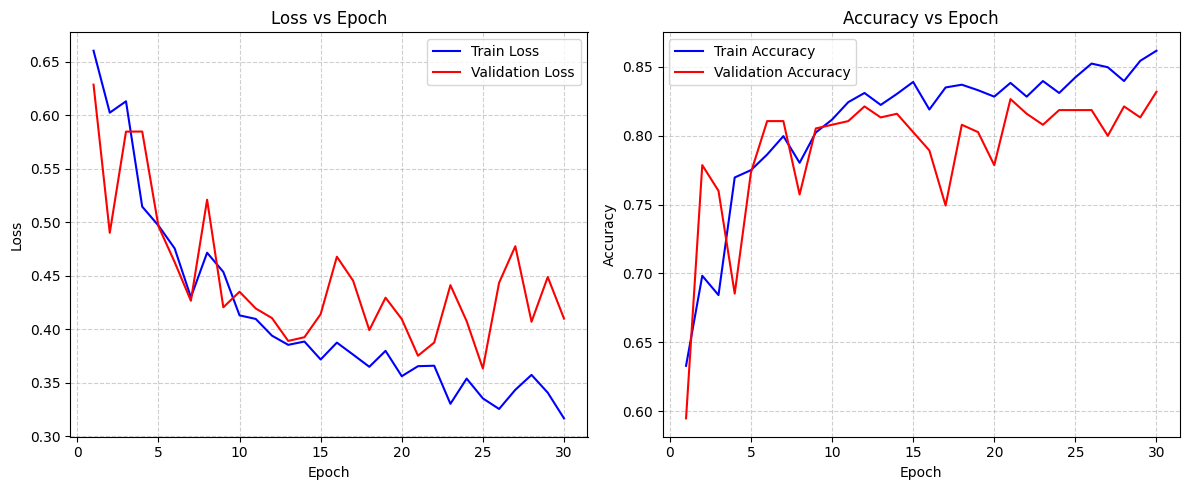

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 1️⃣ Model, criterion, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=2, in_channels=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 2️⃣ Training parameters
num_epochs = 30

# Lists for tracking metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# 3️⃣ Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# 4️⃣ Save the trained model
torch.save(model.state_dict(), "alexnet_glaucoma.pth")
print("Model saved as alexnet_glaucoma.pth")

# 5️⃣ Plot the metrics
plt.figure(figsize=(12,5))

# 📉 Loss
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# 📈 Accuracy
plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_accuracies, 'b-', label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


# Load & Test Model

✅ Model Accuracy: 82.67%

📊 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.78      0.99      0.87       223
    Glaucoma       0.97      0.59      0.73       152

    accuracy                           0.83       375
   macro avg       0.87      0.79      0.80       375
weighted avg       0.86      0.83      0.82       375



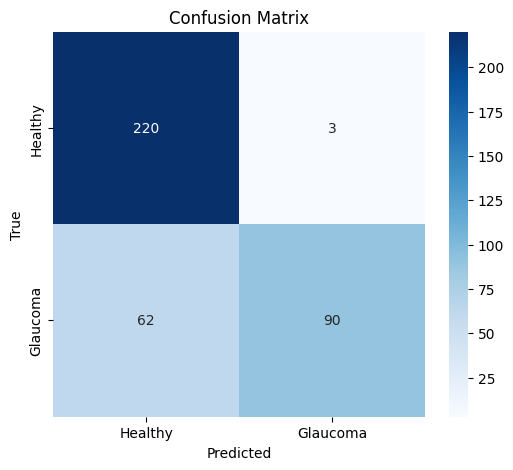

In [9]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Define your class names
classes = ['Healthy', 'Glaucoma']

# 2️⃣ Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=2, in_channels=3).to(device)
model.load_state_dict(torch.load("alexnet_glaucoma.pth", map_location=device))
model.eval()

# 3️⃣ Evaluate on validation or test data
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:  # replace with test_loader if you have test data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4️⃣ Accuracy
accuracy = sum([p == t for p, t in zip(all_preds, all_labels)]) / len(all_labels)
print(f"✅ Model Accuracy: {accuracy * 100:.2f}%")

# 5️⃣ Classification Report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# 6️⃣ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Visualization on overall and glucoma only

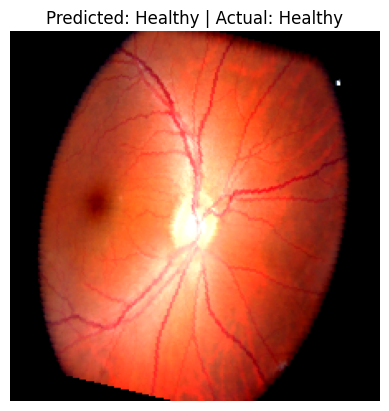

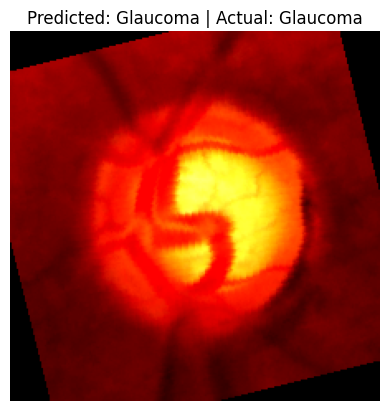

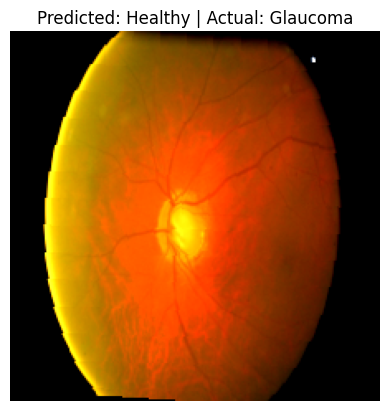

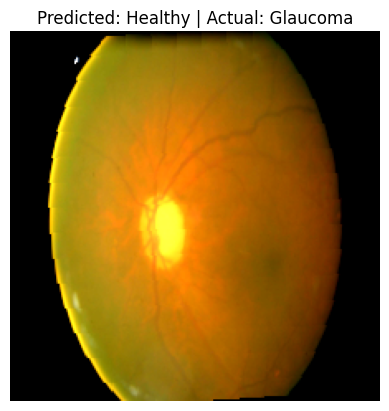

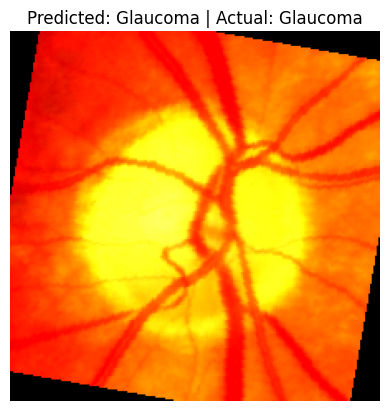


✅ Model Accuracy on this batch: 75.00%


In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Define class names
classes = ['Healthy', 'Glaucoma']

# 2️⃣ Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=2, in_channels=3).to(device)
model.load_state_dict(torch.load("alexnet_glaucoma.pth", map_location=device))
model.eval()

# 3️⃣ Function to show image predictions
def imshow(img, title):
    """
    img: Tensor (C,H,W) normalized in [0,1] or [-1,1]
    """
    img = img.permute(1, 2, 0).cpu().numpy()  # C,H,W -> H,W,C
    # If normalized to [-1,1], convert to [0,1]
    if img.min() < 0:
        img = (img + 1) / 2
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(title, fontsize=12)
    plt.show()

# 4️⃣ Get some random samples from validation/test loader
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# 5️⃣ Get predictions
outputs = model(images)
_, preds = torch.max(outputs, 1)

# 6️⃣ Display first few predictions visually
for i in range(min(5, images.size(0))):  # show up to 5 images
    img = images[i]
    true_label = classes[labels[i].item()]
    pred_label = classes[preds[i].item()]
    color = "green" if true_label == pred_label else "red"
    imshow(img, title=f"Predicted: {pred_label} | Actual: {true_label}")

# 7️⃣ Overall accuracy on this batch
correct = (preds == labels).sum().item()
total = labels.size(0)
accuracy = 100 * correct / total
print(f"\n✅ Model Accuracy on this batch: {accuracy:.2f}%")



🧠 Glaucoma-Only Accuracy: 59.21%

🔍 Sample Predictions (Glaucoma Cases):


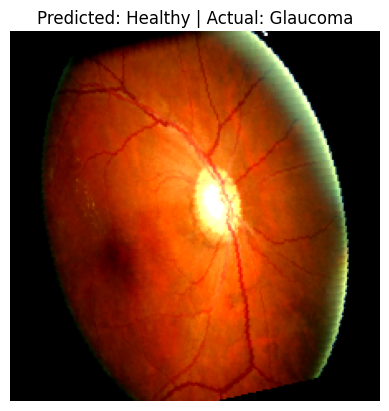

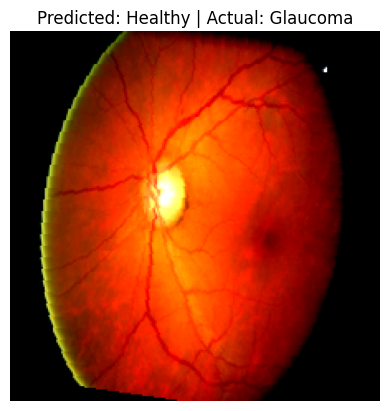

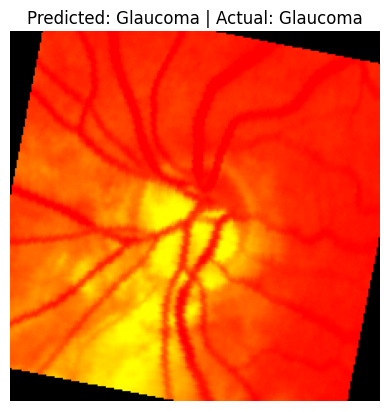

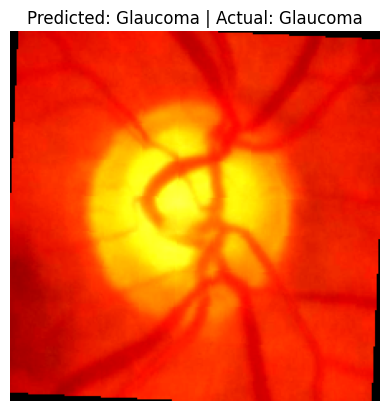

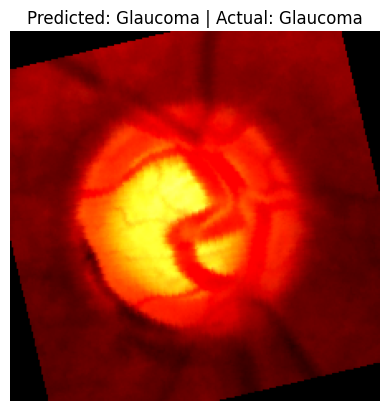

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

classes = ['Healthy', 'Glaucoma']

# 1️⃣ Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=2, in_channels=3).to(device)
model.load_state_dict(torch.load("alexnet_glaucoma.pth", map_location=device))
model.eval()

# 2️⃣ Function to show images
def imshow(img, title):
    """
    img: Tensor (C,H,W) normalized in [-1,1] or [0,1]
    """
    img = img.permute(1, 2, 0).cpu().numpy()  # C,H,W -> H,W,C
    if img.min() < 0:
        img = (img + 1) / 2  # unnormalize if in [-1,1]
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title, fontsize=12)
    plt.show()

# 3️⃣ Collect all glaucoma samples from validation set
glaucoma_indices = [i for i, (_, label) in enumerate(val_loader.dataset) if label == 1]

correct_glaucoma = 0
total_glaucoma = len(glaucoma_indices)

# 4️⃣ Loop over all glaucoma samples to compute accuracy
for idx in glaucoma_indices:
    image, label = val_loader.dataset[idx]
    image = image.unsqueeze(0).to(device)

    output = model(image)
    _, pred = torch.max(output, 1)

    if pred.item() == 1:
        correct_glaucoma += 1

glaucoma_acc = correct_glaucoma / total_glaucoma * 100
print(f"\n🧠 Glaucoma-Only Accuracy: {glaucoma_acc:.2f}%")

# 5️⃣ Randomly pick 5 glaucoma samples to visualize
sample_indices = random.sample(glaucoma_indices, min(5, len(glaucoma_indices)))

print("\n🔍 Sample Predictions (Glaucoma Cases):")
for idx in sample_indices:
    image, label = val_loader.dataset[idx]
    image = image.unsqueeze(0).to(device)

    output = model(image)
    _, pred = torch.max(output, 1)
    pred_label = classes[pred.item()]
    true_label = classes[label]

    imshow(image.squeeze(0), title=f"Predicted: {pred_label} | Actual: {true_label}")
